---
# DecisionTreeClassifier - Model 4
---
In this notebook, we will be looking at the performance of the DecisionTreeClassifier algorithm to accurately forecast clients leaving the company.

## Results
---
The accuracy or performance of an algorithm depends strongly of the goal of the prediction model. In other words, what is the most important in your foreacast? Is it to forecast perfectly the null event? Is it to forecast perfectly the occuring event and minimize the missed event as much as possible?

Since we have a unbalanced dataset, the default accuracy score will forecast more correct null events than correctly occuring events. The missed occuring events and the falsely predicted occuring event will be of the same order.

However, I believe that the client needs is not to have a high accuracy over a unbalanced dataset. The client wants to know which client is leaving which as much precision as possible. In our case, I believe this mean that we want to minimize the missed events (False Negative) while maximizing the correctly predicted occuring event (True positive). This implies having the falsely predicted event (False Positive) higher and the Null Event (True Negative) lower. I believe that this compromised of finding a better balanced accuracy would suit better the need of the client than having a model with a high accuracy, but a low balanced accuracy.

Therefore, for this model, I will be using the scoring method 'balanced_accuracy'.

Various scoring methods and combination of scoring methods with a refit scoring methods were tried (precision, recal, f1, f1_macro, f1_weighted, roc_auc, accuracy, balanced_accuracy) were tried to find the best scoring methods to suit the client need. At the end, the 'balanced_accuracy' scoring method was the most suited to adress the client's needs.

---

### Importing necessary library

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

import joblib

### Read data file

In [2]:
churn_df = pd.read_excel('../data/churn_cleaned_featEng.xlsx')
churn_df

,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value,Senior Citizen_Yes,Partner_Yes,Dependents_Yes,Internet Service_Fiber optic,Internet Service_No,...,Contract_Two year,Paperless Billing_Yes,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,Gender_Male,Phone Service_Yes,Multiple Lines_Yes,Streaming TV_Yes,Streaming Movies_Yes
0,33.964131,118.272783,2,53.85,1,0,0,0,0,0,...,0,1,0,0,1,1,1,0,0,0
1,34.059281,118.307420,2,70.70,1,0,0,1,1,0,...,0,1,0,1,0,0,1,0,0,0
2,34.048013,118.293953,8,99.65,1,0,0,1,1,0,...,0,1,0,1,0,0,1,1,1,1
3,34.062125,118.315709,28,104.80,1,0,1,1,1,0,...,0,1,0,1,0,0,1,1,1,1
4,34.039224,118.266293,49,103.70,1,0,0,1,1,0,...,0,1,0,0,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,34.341737,116.539416,72,21.15,0,0,0,0,0,1,...,1,1,0,0,0,0,1,0,0,0
7039,34.667815,117.536183,24,84.80,0,0,1,1,0,0,...,0,1,0,0,1,1,1,1,1,1
7040,34.559882,115.637164,72,103.20,0,0,1,1,1,0,...,0,1,1,0,0,0,1,1,1,1
7041,34.167800,116.864330,11,29.60,0,0,1,1,0,0,...,0,1,0,1,0,0,0,0,0,0


---

<center>
    
## Preparing data

</center>

---

### Separate X and y features

In [3]:
X = churn_df.drop(columns=['Churn Value'])
y = churn_df['Churn Value']

### Split dataset (training/testing)

In [4]:
# Separating the dataset into a training dataset (70%) and testing+validation (30%) dataset
X_train, X_test_validation, y_train, y_test_validation = train_test_split(X, y, train_size=0.7, random_state=5)

# Separating the testing+valisation dataset into a testing dataset (15%) and a validation dataset (15%) 
X_val, X_test, y_val, y_test = train_test_split(X_test_validation, y_test_validation, test_size=0.5, random_state=5)

### Converting data subset to dataframe 

In [5]:
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

### Scale X features

In [6]:
# Create instance of scaler
scaler = StandardScaler()

# Scale the data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

---

<center>
    
## Decision Tree Model

</center>

---

### Find best parameters for model
---

**Create intance of model**

In [7]:
dtc = DecisionTreeClassifier(random_state=25) #'balanced'

**Setting parameters for the GridSearch**

In [8]:
param_grid = { 'criterion' : ['gini', 'entropy', 'log_loss'],
               'splitter' : ['best','random'],
               'max_depth' : [3,4,5,6,7,8,9,10],
               'class_weight': ['balanced', {0: 1, 1: 1}, {0: 0.7, 1: 1.3}, {0: 0.5, 1: 1.5}, {0: 0.3, 1: 1.7}, {0: 0.1, 1: 1.9}],
               'max_features' :['sqrt', 'log2', None]
             }

scoring = 'balanced_accuracy'


**Setting instance of GridSearchCV**

In [9]:
grid = GridSearchCV(dtc, param_grid, scoring=scoring)#, refit=refit)

**Train the models to find best parameters**

In [10]:
grid.fit(X_train_scaled,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=25),
             param_grid={'class_weight': ['balanced', {0: 1, 1: 1},
                                          {0: 0.7, 1: 1.3}, {0: 0.5, 1: 1.5},
                                          {0: 0.3, 1: 1.7}, {0: 0.1, 1: 1.9}],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': ['sqrt', 'log2', None],
                         'splitter': ['best', 'random']},
             scoring='balanced_accuracy')

---
### Investigate best model's predictive features

---

In [11]:
grid.best_params_

{'class_weight': {0: 0.5, 1: 1.5},
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': None,
 'splitter': 'best'}

In [12]:
grid.best_score_

np.float64(0.7707100892840882)

In [13]:
grid.n_features_in_

24

In [14]:
best_model = grid.best_estimator_

# Get feature importances from the best model
feature_importance = best_model.feature_importances_
#feature_importance = best_model.named_steps['dtc'].feature_importances_

feature_importance

array([0.03549876, 0.01444917, 0.09923935, 0.02731295, 0.00368255,
       0.        , 0.09363055, 0.09286878, 0.01344913, 0.00389362,
       0.        , 0.        , 0.        , 0.20922874, 0.35471684,
       0.        , 0.        , 0.00619569, 0.        , 0.        ,
       0.01204122, 0.        , 0.        , 0.03379264])

In [15]:
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)
feature_importance_df

,Feature,Importance
0,Contract_Two year,0.354717
1,Contract_One year,0.209229
2,Tenure Months,0.099239
3,Dependents_Yes,0.093631
4,Internet Service_Fiber optic,0.092869
5,Latitude,0.035499
6,Streaming Movies_Yes,0.033793
7,Monthly Charges,0.027313
8,Longitude,0.014449
9,Internet Service_No,0.013449


In [16]:
grid.best_estimator_.predict_proba(X_train_scaled)

array([[0.25070956, 0.74929044],
       [0.25070956, 0.74929044],
       [0.2625    , 0.7375    ],
       ...,
       [1.        , 0.        ],
       [0.59139785, 0.40860215],
       [1.        , 0.        ]], shape=(4930, 2))

**Plot Decision Tree Arborescence**

In [18]:
# Create figure and adjust size
plt.figure(figsize=(100,100))

# Plot decision tree
plot_tree(best_model, feature_names=X_train.columns)

# Save decision tree
plt.savefig('../graph/DecisionTreeClassifier.png')

# Show model
plt.show()

---
### Get scores for the training dataset
---

**Make prediction on training dataset**

In [19]:
y_pred_train = grid.predict(X_train_scaled)

**Create Confusion Matrix**

In [20]:
cm = confusion_matrix(y_train, y_pred_train)
cm

array([[2586, 1015],
       [ 170, 1159]])

**Plot confusion matrix**

<Figure size 400x400 with 0 Axes>

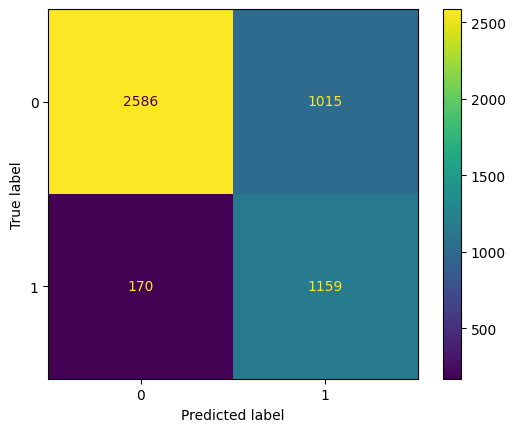

In [21]:
# Create figure and adjsut its size
plt.figure(figsize=(4,4))

# Create plot for Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=grid.classes_)

disp.plot()

# Show plot
plt.show()

**Print classification Report**

In [22]:
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       0.94      0.72      0.81      3601
           1       0.53      0.87      0.66      1329

    accuracy                           0.76      4930
   macro avg       0.74      0.80      0.74      4930
weighted avg       0.83      0.76      0.77      4930



---

<center>
    
## Validation

</center>

---

**Run model on testing dataset**

In [23]:
y_pred_test = grid.predict(X_test_scaled)

**Create Confusion Matrix**

In [24]:
cm = confusion_matrix(y_test, y_pred_test)
cm

array([[523, 260],
       [ 37, 237]])

**Plot confusion matrix**

<Figure size 400x400 with 0 Axes>

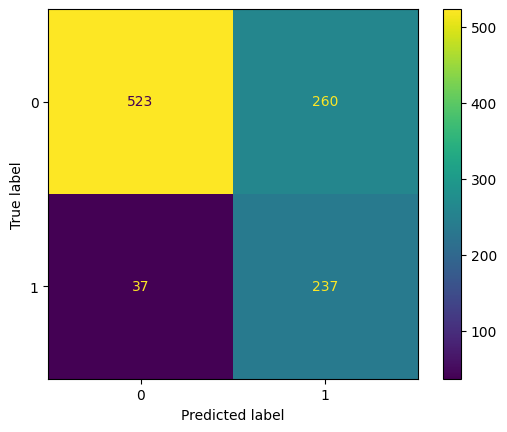

In [25]:
# Create figure and adjsut its size
plt.figure(figsize=(4,4))

# Create plot for Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=grid.classes_)

disp.plot()

# Show plot
plt.show()

**Print classification Report**

In [26]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.93      0.67      0.78       783
           1       0.48      0.86      0.61       274

    accuracy                           0.72      1057
   macro avg       0.71      0.77      0.70      1057
weighted avg       0.82      0.72      0.74      1057



---

<center>
    
## Results

</center>

---



**Explanation of Metrics:**

>    **Precision**: The proportion of true positive predictions out of all positive predictions.</br>
     **Recall**: The proportion of true positive predictions out of all actual positive instances.</br>
     **F1-score**: The harmonic mean of precision and recall, balancing both metrics.</br>
     **Support**: The number of actual occurrence</br>

### Results

**DecisionTreeClassifier** (scoring=balanced_accuracy, class_weights={0: 0.5, 1: 1.5})
|               | Precision | Recall | F1-Score | Support |
|---------------|----------|-------|---------|--------|
| Class 0       | 0.93     | 0.67  | 0.78    | 783    |
| Class 1       | 0.48     | 0.86  | 0.61    | 274    |
| Accuracy      | -        | - | 0.72        | 1057   |
| Macro Avg     | 0.71     | 0.77  | 0.70    | 1057   |
| Weighted Avg  | 0.82     | 0.72  | 0.74    | 1057   |

</br></br>
**K-Nearest Neighbor** (weights=uniform)

|               | Precision | Recall | F1-Score | Support |
|---------------|:---------:|:------:|:-------:|:-------:|
| **Class 0**   | 0.83     | 0.81   | 0.82    | 783     |
| **Class 1**   | 0.49     | 0.51   | 0.50    | 274     |
| **Accuracy**  | -        | -   | 0.74        | 1057    |
| **Macro Avg** | 0.66     | 0.66   | 0.66    | 1057    |
| **Weighted Avg** | 0.74     | 0.74   | 0.74    | 1057    |

</br></br>
**Random Forest** (scoring=accuracy, class_weights={0: 1, 1: 1})
|               | Precision | Recall | F1-Score | Support |
|---------------|:---------:|:------:|:-------:|:-------:|
| **Class 0**   | 0.86     | 0.90   | 0.88    | 783     |
| **Class 1**   | 0.66     | 0.57   | 0.61    | 274     |
| **Accuracy**  | -        | -      | 0.81    | 1057    |
| **Macro Avg** | 0.76     | 0.73   | 0.74    | 1057    |
| **Weighted Avg** | 0.81     | 0.81   | 0.81    | 1057    |

</br></br>
**Logistic Regression**
|               | Precision | Recall | F1-Score | Support |
|---------------|:---------:|:------:|:-------:|:-------:|
| **Class 0**   | 0.84     | 0.91   | 0.87    | 783     |
| **Class 1**   | 0.65     | 0.49   | 0.56    | 274     |
| **Accuracy**  | -        | -      | 0.80    | 1057    |
| **Macro Avg** | 0.74     | 0.70   | 0.71    | 1057    |
| **Weighted Avg** | 0.79     | 0.80   | 0.79    | 1057    |


---

<center>
    
## Results

</center>

---

### Saving the most balanced model

In [29]:
joblib.dump(best_model, "../model/best_balanced_model.joblib")
joblib.dump(scaler, "../model/best_balanced_model_scaler.joblib")

['../model/best_balanced_model_scaler.joblib']